# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id = string, id used in the screenshot folder to identify this record
* start = datetime (in the format: 26/05/2009 22:00:00), start of this trade
* timeframe = string, possible values are 2D,D,H12,H8
* entry = float, entry price
* outcome = string, possible values are S=success;F=failure;B=breakeven.Outcome of the trace
* RSI bounces = integer. Number of RSI bounces ocurring in the trend before entry
* No of candles = integer. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI = boolean. True= Entry on oversold/overbought region, False= Entry NOT on oversold/overbought region
* length of trend = integer. Length of the preceding trend in number of candles. The valley before the continuation is not included in the count
* strong trend = boolean. True if the trend is strong, otherwise is False
* trend angle = integer. Angle of the trend
* bounce length = integer. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* retraced = integer. Only relevant when outcome is 'F', how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed
* last time = datetime (in the format 26/05/2009), last time that the price was below/above this level

## Dependencies

In [368]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [369]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.csv',sep=",",na_values=["n.a.","n.a"])

contDF.shape

(59, 17)

And some information about contDF:

In [370]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 17 columns):
id                         59 non-null object
start                      56 non-null object
timeframe                  56 non-null object
entry                      56 non-null float64
outcome                    59 non-null object
Candle +1 against trade    59 non-null bool
RSI bounces                59 non-null int64
No of candles              53 non-null float64
bounce length              53 non-null object
entry on RSI               59 non-null bool
length of trend            59 non-null int64
strong trend               59 non-null bool
trend angle                56 non-null float64
retraced                   19 non-null float64
last time                  57 non-null object
target                     3 non-null object
congestion                 3 non-null object
dtypes: bool(3), float64(4), int64(2), object(8)
memory usage: 6.7+ KB


## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [371]:
contDF['outcome'].value_counts()

S    30
F    26
B     3
Name: outcome, dtype: int64

For now I am not going to consider the trades having an outcome of 'B'. So, let's remove them from the dataframe:

In [372]:
contDF=contDF[contDF.outcome != 'B']

### Candle +1 against trade
This variable is True when the IC+1 is against the trade. I will here analyze the influence of this variable on the outcome

Let's create a contigency table analysing the relationship between these 2 variables:

In [373]:
div_class=pd.crosstab(contDF['outcome'], contDF['Candle +1 against trade'],margins=True)
print(div_class)

Candle +1 against trade  False  True  All
outcome                                  
F                           17     9   26
S                           26     4   30
All                         43    13   56


It's is easier to visualize the relationship if we calculate the percentages:

In [374]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

Candle +1 against trade       False        True         All
outcome                                                    
F                         39.534884   69.230769   46.428571
S                         60.465116   30.769231   53.571429
All                      100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

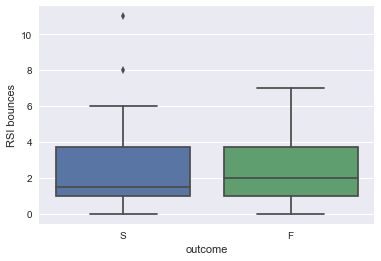

In [375]:
ax = sns.boxplot(x="outcome", y="RSI bounces", data=contDF)

* Mean for each category

In [376]:
contDF.groupby(['outcome']).agg({'RSI bounces': 'mean'})

,RSI bounces
outcome,
F,2.384615
S,2.600000


* Median for each category

In [377]:
medianBounce=contDF.groupby(['outcome']).agg({'RSI bounces': 'median'})
print(medianBounce)

         RSI bounces
outcome             
F                2.0
S                1.5


* Conclusion <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>

* Distribution of the number of bounces
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

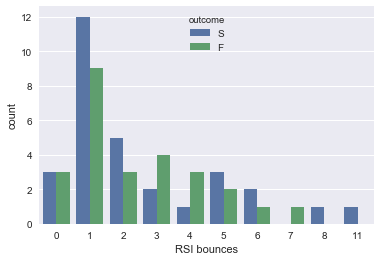

In [378]:
ax = sns.countplot(x="RSI bounces",hue="outcome", data=contDF)

### retraced
This integer variable represents the number of pips from the S/L from where the failing trade retraced and hitted the target. Let's start analyzing the number of trades that retraced:

In [379]:
len(contDF[contDF.retraced.notnull()])

18

Now, let's examine the distribution of the data:

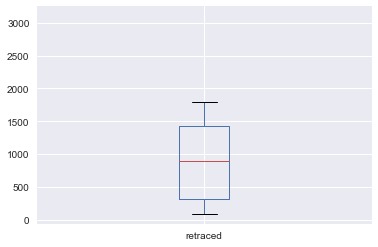

In [380]:
ret=contDF[contDF.retraced.notnull()].retraced.astype(int)
ret.plot(kind="box")

In [381]:
print(ret.describe())

count      18.000000
mean      968.333333
std       791.998589
min        90.000000
25%       317.500000
50%       900.000000
75%      1425.000000
max      3100.000000
Name: retraced, dtype: float64


### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>
First, I will remove the NaN cases (cases where there were not RSI bounces in the trade)

In [382]:
contDF_dropna=contDF.dropna(subset=['No of candles'])

As an initial exploration I will create a boxplot displaying the data:

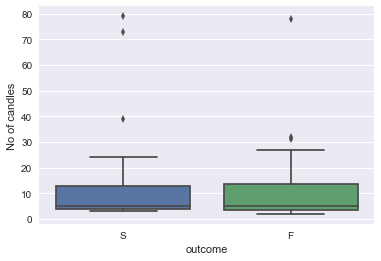

In [383]:
ax = sns.boxplot(x="outcome", y="No of candles", data=contDF_dropna)

* Mean for each category

In [384]:
contDF.groupby(['outcome']).agg({'No of candles': 'mean'})

,No of candles
outcome,
F,12.913043
S,13.962963


* Median for each category

In [385]:
contDF.groupby(['outcome']).agg({'No of candles': 'median'})

,No of candles
outcome,
F,5.0
S,5.0


### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [386]:
contDF['entry on RSI'].value_counts()

False    41
True     15
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [387]:
div_class=pd.crosstab(contDF['outcome'], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI  False  True  All
outcome                       
F                20     6   26
S                21     9   30
All              41    15   56


It's is easier to visualize the relationship if we calculate the percentages:

In [388]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI       False   True         All
outcome                                    
F              48.780488   40.0   46.428571
S              51.219512   60.0   53.571429
All           100.000000  100.0  100.000000


* Conclusion <br>
Within the trades having entry on RSI there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades not having an entry on RSI there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

### length of trend
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

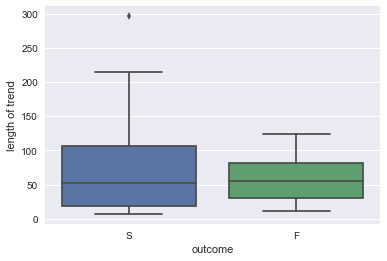

In [389]:
ax = sns.boxplot(x="outcome", y="length of trend", data=contDF)

* Mean for each category

In [390]:
contDF.groupby(['outcome']).agg({'length of trend': 'mean'})

,length of trend
outcome,
F,59.307692
S,72.300000


* Median for each category

In [391]:
contDF.groupby(['outcome']).agg({'length of trend': 'median'})

,length of trend
outcome,
F,55.5
S,52.0


###  trend angle
This quantitative discrete variable measures the angle of a particular trend. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

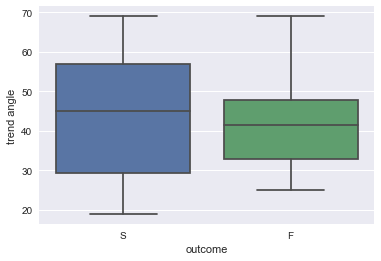

In [392]:
ax = sns.boxplot(x="outcome", y="trend angle", data=contDF)

* Mean for each category

In [393]:
contDF.groupby(['outcome']).agg({'trend angle': 'mean'})

,trend angle
outcome,
F,41.461538
S,44.066667


* Median for each category

In [394]:
contDF.groupby(['outcome']).agg({'trend angle': 'median'})

,trend angle
outcome,
F,41.5
S,45.0


### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [395]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

Now, I am going to remove the NaN values from the variable

In [396]:
contDF_dropna=contDF.dropna(subset=['bounce length'])

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [399]:
contDF_dropna['sum_bounces']=contDF_dropna['bounce length'].astype(str).apply(sum_lengths)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now, I will plot the distribution of this new variable on each `outcome`category:

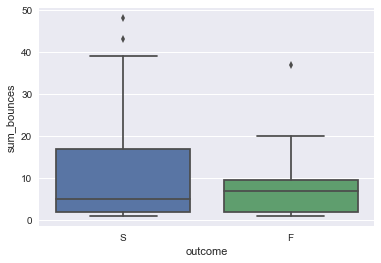

In [402]:
ax = sns.boxplot(x="outcome", y="sum_bounces", data=contDF_dropna)

* Mean for each category

In [403]:
contDF_dropna.groupby(['outcome']).agg({'sum_bounces': 'mean'})

,sum_bounces
outcome,
F,7.956522
S,11.148148


* Median for each category

In [404]:
contDF_dropna.groupby(['outcome']).agg({'sum_bounces': 'median'})

,sum_bounces
outcome,
F,7
S,5
